In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.spatial.distance import cdist

In [2]:
def read_spatial_expression(file,sep='\s+',
                            num_exp_genes=0.01, num_exp_spots=0.01, min_expression=1,
                            drop = False):
    
    '''
    Read raw data and returns pandas data frame of spatial gene express
    and numpy ndarray for single cell location coordinates; 
    Meanwhile processing raw data.
    
    :param file: csv file for spatial gene expression; 
    :rtype: coord (spatial coordinates) shape (n, 2); data: shape (n, m); 
    '''
    counts = pd.read_csv(file, sep=sep, index_col = 0)
    print('raw data dim: {}'.format(counts.shape))

    num_spots = len(counts.index)
    num_genes = len(counts.columns)
    min_genes_spot_exp = round((counts != 0).sum(axis=1).quantile(num_exp_genes))
    print("Number of expressed genes a spot must have to be kept " \
    "({}% of total expressed genes) {}".format(num_exp_genes, min_genes_spot_exp))
    
    mark_points = np.where((counts != 0).sum(axis=1) < min_genes_spot_exp)[0]
    print("Marked {} spots".format(len(mark_points)))
    
    if len(mark_points)>0:
        noiseInd = [counts.shape[0]-1-i for i in range(len(mark_points))]
        if drop == False:
            temp = [val.split('x') for val in counts.index.values]
            coord = np.array([[float(a[0]), float(a[1])] for a in temp])

            similar_points=np.argsort(cdist(coord[mark_points,:],coord),axis=1)[:,1]
            for i,j in zip(mark_points,similar_points):
                counts.iloc[i,:]=counts.iloc[j,:]
        
            mark_counts=counts.iloc[mark_points,:]
            dropped_counts = counts.drop(counts.index[mark_points])
            counts=pd.concat([dropped_counts,mark_counts])  
            
        else:    
            counts = counts[(counts != 0).sum(axis=1) >= min_genes_spot_exp]
    else:
        counts = counts
        noiseInd =[] 
    
    # Spots are columns and genes are rows
    counts = counts.transpose()
    # Remove noisy genes
    min_features_gene = round(len(counts.columns) * num_exp_spots) 
    print("Removing genes that are expressed in less than {} " \
    "spots with a count of at least {}".format(min_features_gene, min_expression))
    counts = counts[(counts >= min_expression).sum(axis=1) >= min_features_gene]
    print("Dropped {} genes".format(num_genes - len(counts.index)))
    
    temp = [val.split('x') for val in counts.columns.values]
    coord = np.array([[float(a[0]), float(a[1])] for a in temp])

    data=counts.transpose()

    return coord,data, noiseInd

In [3]:
data_dir = '../dataset/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv'
locs,data,_=read_spatial_expression(data_dir)
locs_df = pd.DataFrame(locs,columns=['imagerow', 'imagecol'])
locs_df.index = data.index
adata = sc.AnnData(X=data,
                        obs=locs_df)

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes


In [4]:
adata

AnnData object with n_obs × n_vars = 262 × 14659
    obs: 'imagerow', 'imagecol'

In [5]:
target_gene = 'Sparcl1'

In [6]:
exp = adata[:,target_gene].X.toarray()

In [7]:
from sklearn.mixture import GaussianMixture

In [8]:
gmm = GaussianMixture(n_components=2)
gmm.fit(exp)
labels = gmm.predict(exp)

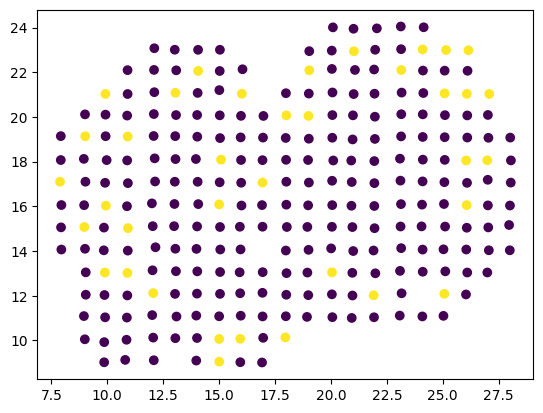

In [9]:
from matplotlib import pyplot as plt
plt.scatter(locs[:,0],locs[:,1],c=labels)


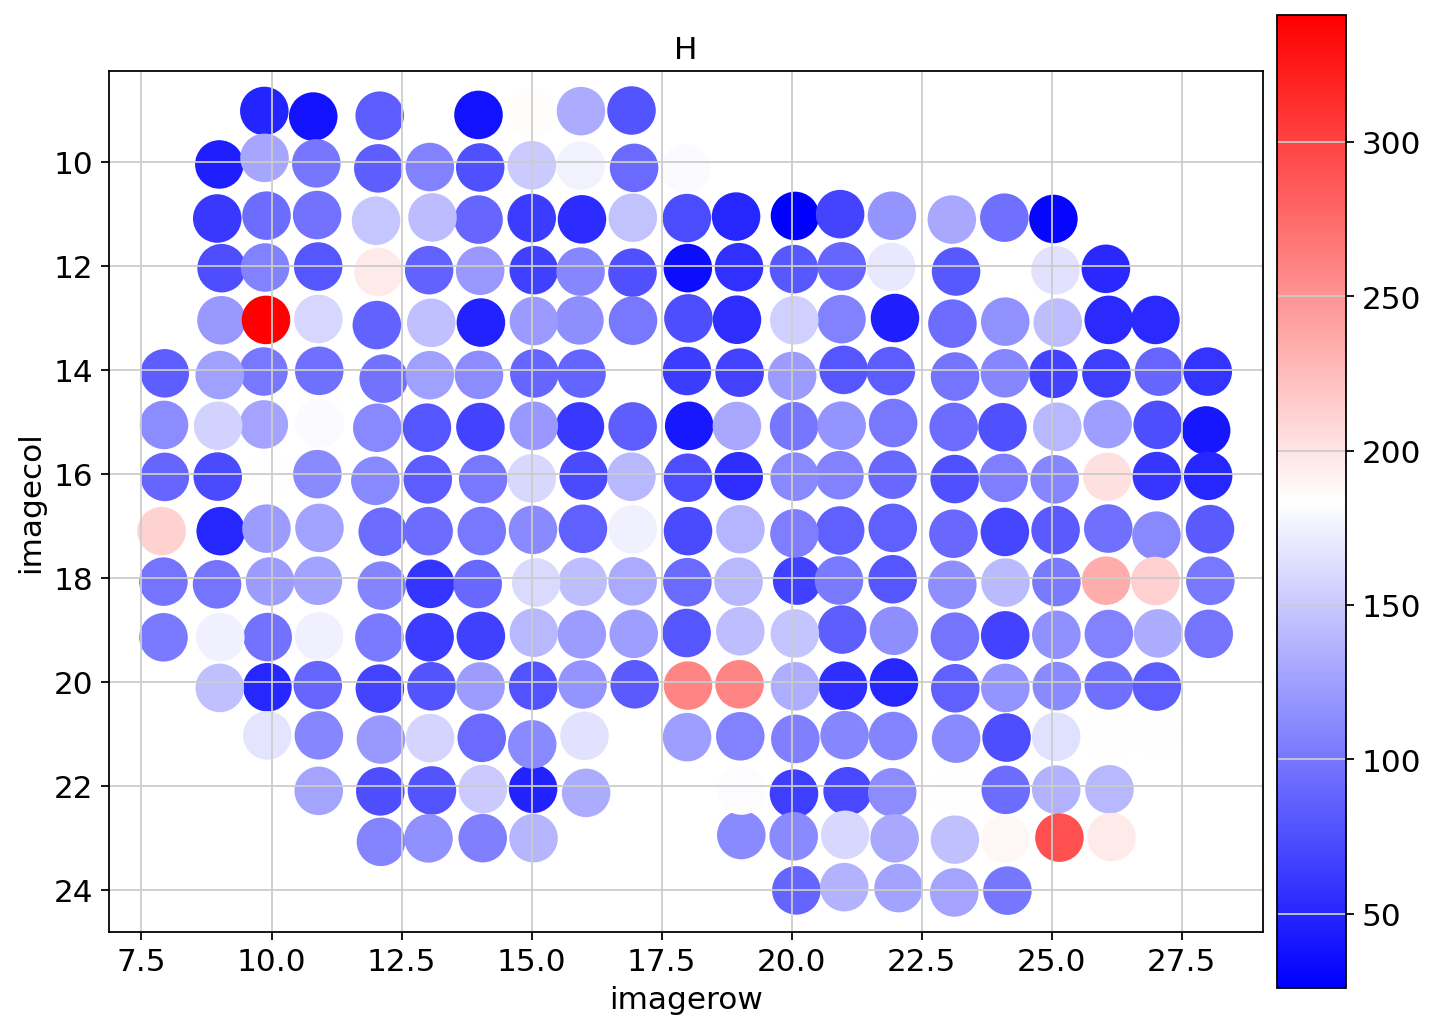

In [10]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
ax=sc.pl.scatter(adata,alpha=1,x="imagerow",y="imagecol", color = target_gene,
                 title='H',show=False,size=500000/adata.shape[0],
                color_map='bwr')
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

In [13]:
from src import * 

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from scipy import sparse as sp

In [15]:
def get_binary_weight(adata, radius = 1):
    coor = adata.obs
    coor = coor.loc[:,['imagerow', 'imagecol']]
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    nbrs = NearestNeighbors(radius = radius).fit(coor)
    distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
    KNN_list = []
    for it in range(indices.shape[0]):
        KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']
    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    
    #out = pd.get_dummies(Spatial_Net.set_index("Cell1")['Cell2'],sparse=True).max(level=0)
    G_df = Spatial_Net
    cells = np.array(adata.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)
    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])
        
    return G

In [19]:
cellGraph = get_binary_weight(adata, radius = 1)

In [ ]:
from src import * 

  (0, 0)	1.0
  (0, 13)	1.0
  (1, 1)	1.0
  (1, 2)	1.0
  (1, 17)	1.0
  (2, 1)	1.0
  (2, 2)	1.0
  (2, 258)	1.0
  (3, 3)	1.0
  (3, 4)	1.0
  (3, 26)	1.0
  (4, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (5, 7)	1.0
  (6, 6)	1.0
  (6, 67)	1.0
  (7, 5)	1.0
  (7, 7)	1.0
  (7, 65)	1.0
  (8, 8)	1.0
  (8, 10)	1.0
  (8, 34)	1.0
  (9, 9)	1.0
  (10, 8)	1.0
  :	:
  (251, 250)	1.0
  (251, 251)	1.0
  (251, 256)	1.0
  (252, 252)	1.0
  (252, 255)	1.0
  (253, 248)	1.0
  (253, 253)	1.0
  (254, 254)	1.0
  (255, 252)	1.0
  (255, 255)	1.0
  (256, 251)	1.0
  (256, 256)	1.0
  (257, 167)	1.0
  (257, 208)	1.0
  (257, 257)	1.0
  (258, 2)	1.0
  (258, 222)	1.0
  (258, 258)	1.0
  (259, 259)	1.0
  (260, 188)	1.0
  (260, 213)	1.0
  (260, 260)	1.0
  (261, 155)	1.0
  (261, 227)	1.0
  (261, 261)	1.0


In [36]:
cellGraph[0].indptr

array([0, 2], dtype=int32)

In [38]:
for cell in cellGraph:
    print(cell.indices)

[ 0 13]
[ 1  2 17]
[  1   2 258]
[ 3  4 26]
[3 4]
[5 7]
[ 6 67]
[ 5  7 65]
[ 8 10 34]
[9]
[ 8 10 30]
[11]
[12 13]
[ 0 12 13]
[14 16]
[15 17]
[14 16 21]
[ 1 15 17]
[18 19 20]
[18 19 25]
[18 20 21 32]
[16 20 21]
[22 24 25]
[23 25 41]
[22 24]
[19 22 23 25]
[ 3 26 27 29]
[26 27 28]
[27 28 29]
[26 28 29]
[10 30 33]
[31 41]
[20 32]
[30 33 35 40]
[  8  34 193]
[ 33  35  37 192]
[36 47 97]
[ 35  37 194]
[38]
[39 45]
[33 40]
[23 31 41]
[42 44 60]
[43 52]
[42 44 57]
[39 45]
[46 49 98]
[36 47 99]
[ 48 100]
[ 46  49  52 101]
[50 51]
[50 51 61]
[43 49 52]
[53 56]
[54 55]
[54 55]
[53 56 65]
[44 57 59]
[58]
[57 59]
[42 60 62]
[51 61 62]
[60 61 62]
[63 64 66]
[63 64 68]
[ 7 56 65 68]
[63 66 67 68]
[ 6 66 67]
[64 65 66 68]
[69 70 73 92]
[ 69  70  74 108]
[71 72 90]
[71 72 73]
[69 72 73]
[70 74]
[75 77 79]
[ 76  79  80 106]
[75 77 83]
[78 79 80 82]
[75 76 78 79]
[ 76  78  80  85 107]
[81 86 87]
[78 82 85]
[77 83]
[84 89]
[ 80  82  85 111]
[ 81  86  88 112]
[ 81  87  88 103]
[ 86  87  88 110 195]
[84 89]